# Wildfire Prediction

This Jupyter Notebook implements various MLPs and CNNs to predict whether a landscape image represents a wildfire or not. PyTorch will be the main library used for this project. 

Image Specifications:
- Type: `.jpg`
- Dimensions: 250 x 250 pixels
- Horizontal/vertical resolution: 96 dpi
- Bit depth: 24

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
import gc

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Create train, validation, and test sets
torch.manual_seed(42)

train_validation_set = torchvision.datasets.ImageFolder('forest_fire/Training and Validation', transform)
train_size = int(0.8 * len(train_validation_set))
val_size = len(train_validation_set) - train_size

train_set, val_set = random_split(train_validation_set, [train_size, val_size])

train_loader = DataLoader(
    train_set,
    batch_size = 64,
    shuffle = True
)

val_loader = DataLoader(
    val_set,
    batch_size = 64, 
    shuffle = False
)

test_set = torchvision.datasets.ImageFolder('forest_fire/Testing', transform)
test_loader = DataLoader(
    test_set,
    batch_size = 64,
    shuffle = False
)

In [4]:
# Global constants
input_size = 250 * 250 * 3
classes = ['fire', 'nofire']
num_classes = 2
num_epochs = 20

# Eight different MLP architectures to experiment
mlp_hidden_sizes = [
    [64],
    [128, 64],
    [256, 64],
    [512, 128],
    [256, 128, 64],
    [1024, 256, 64],
    [512, 256, 128, 64],
    [1024, 512, 256, 128, 64]
]

# Nine different CNN architectures to experiment
conv_sizes = [3, 5, 7]
cnn_hidden_sizes = [
    [32],
    [32, 64],
    [32, 64, 128]
]

In [5]:
# Create a dynamic Multi-layer Perceptron
class DynamicMLP(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(DynamicMLP, self).__init__()
        layers = [nn.Flatten()]

        # Construct MLP
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size

        # Make output layer
        layers.append(nn.Linear(prev_size, num_classes))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [6]:
# Create a dynamic Convolutional Neural Network
class DynamicCNN(nn.Module):
    
    def __init__(self, hidden_sizes, conv_size, num_classes):
        super(DynamicCNN, self).__init__()
        layers = []

        # Construct CNN
        curr_layer = 3 # initially RGB channels
        img_dim = 250 # image dimension
        for hidden_size in hidden_sizes:
            padding = conv_size // 2
            layers.append(nn.Conv2d(curr_layer, hidden_size, kernel_size=conv_size, padding=padding))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            img_dim = img_dim // 2
            curr_layer = hidden_size

        # Output layer
        # print(img_dim * img_dim * curr_layer)
        layers.append(nn.Flatten())
        layers.append(nn.Linear(img_dim * img_dim * curr_layer, num_classes))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [7]:
# Training and validation loop
def train_loop(train_model, train_loader, val_loader, num_epochs, model_num):

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = train_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_nums = np.arange(1, 21)
    train_accuracies = []
    val_accuracies = []

    if type(train_model) == DynamicMLP:
        file_name = f"mlp_results/mlp{model_num}_results_log.txt"
    else:
        file_name = f"mlp_results/mlp{model_num}_results_log.txt"

    with open(file_name, 'w') as f:
        for epoch in range(num_epochs):

            # TRAINING
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct / total
            train_accuracies.append(train_accuracy)

            # VALIDATION
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = 100 * val_correct / val_total
            val_accuracies.append(val_accuracy)

            epoch_str = f"Epoch [{epoch+1}/{num_epochs}]"
            train_str = f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%"
            val_str = f"Validation Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n"

            print(epoch_str)
            print(train_str)
            print(val_str)

            f.write(epoch_str +'\n')
            f.write(train_str + '\n')
            f.write(val_str + '\n')

    plt.plot(epoch_nums, train_accuracies)
    plt.xticks(np.arange(1, 21))
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy vs. Epoch Line Graph')
    if type(model) == DynamicMLP:
        plt.savefig(f"mlp_results/mlp{model_num}_train_acc_plot.png")
    else:
        plt.savefig(f"cnn_results/cnn{model_num}_train_acc_plot.png")
    plt.show()

    plt.plot(epoch_nums, val_accuracies)
    plt.xticks(np.arange(1, 21))
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs. Epoch Line Graph')
    if type(model) == DynamicMLP:
        plt.savefig(f"mlp_results/mlp{model_num}_validation_acc_plot.png")
    else:
        plt.savefig(f"cnn_results/cnn{model_num}_validation_acc_plot.png")
    plt.show()

In [8]:
# Testing loop
def test_loop(model, test_loader, model_num):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    running_loss = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total

    if type(model) == DynamicMLP:
        file_name = f"mlp_results/mlp{model_num}_results_log.txt"
    else:
        file_name = f"cnn_results/mlp{model_num}_results_log.txt"

    with open(file_name, 'a') as f:
        test_str = f"Test Loss: {avg_loss:4f}, Test Accuracy: {accuracy:2f}%"
        print(test_str)
        f.write(test_str + '\n')

In [9]:
def run_process(model, train_loader, val_loader, test_loader, num_epochs, model_num):
    train_loop(model, train_loader, val_loader, num_epochs, model_num)
    test_loop(model, test_loader, model_num)

In [10]:
# Create the MLPs
mlp_1 = DynamicMLP(input_size, mlp_hidden_sizes[0], num_classes)
mlp_2 = DynamicMLP(input_size, mlp_hidden_sizes[1], num_classes)
mlp_3 = DynamicMLP(input_size, mlp_hidden_sizes[2], num_classes)
mlp_4 = DynamicMLP(input_size, mlp_hidden_sizes[3], num_classes)
mlp_5 = DynamicMLP(input_size, mlp_hidden_sizes[4], num_classes)
mlp_6 = DynamicMLP(input_size, mlp_hidden_sizes[5], num_classes)
mlp_7 = DynamicMLP(input_size, mlp_hidden_sizes[6], num_classes)
mlp_8 = DynamicMLP(input_size, mlp_hidden_sizes[7], num_classes)
mlps = [mlp_1, mlp_2, mlp_3, mlp_4, mlp_5, mlp_6, mlp_7, mlp_8]

In [19]:
# Create the CNNs

# Architecture 1
cnn_1 = DynamicCNN(cnn_hidden_sizes[0], conv_sizes[0], num_classes)
cnn_2 = DynamicCNN(cnn_hidden_sizes[0], conv_sizes[1], num_classes)
cnn_3 = DynamicCNN(cnn_hidden_sizes[0], conv_sizes[2], num_classes)

# Architecture 2
cnn_4 = DynamicCNN(cnn_hidden_sizes[1], conv_sizes[0], num_classes)
cnn_5 = DynamicCNN(cnn_hidden_sizes[1], conv_sizes[1], num_classes)
cnn_6 = DynamicCNN(cnn_hidden_sizes[1], conv_sizes[2], num_classes)

# Architecture 3
cnn_7 = DynamicCNN(cnn_hidden_sizes[2], conv_sizes[0], num_classes)
cnn_8 = DynamicCNN(cnn_hidden_sizes[2], conv_sizes[1], num_classes)
cnn_9 = DynamicCNN(cnn_hidden_sizes[2], conv_sizes[2], num_classes)

cnns = [cnn_1, cnn_2, cnn_3, cnn_4, cnn_5, cnn_6, cnn_7, cnn_8, cnn_9]

In [ ]:
# Loop to train, validate, and test all MLPs (last run took 25 minutes)
for i in range(8):
    print(f'Now running MLP #{i+1}...')
    run_process(mlps[i], train_loader, val_loader, test_loader, num_epochs, i + 1)

    torch.save(mlps[i].state_dict(), f"mlp_models/mlp_{i+1}.pth")

Epoch [1/20]
Train Loss: 0.2895, Train Accuracy: 91.81%
Validation Loss: 0.2895, Validation Accuracy: 94.28%

Epoch [2/20]
Train Loss: 0.1422, Train Accuracy: 95.15%
Validation Loss: 0.1422, Validation Accuracy: 93.19%

Epoch [3/20]
Train Loss: 0.1014, Train Accuracy: 96.79%
Validation Loss: 0.1014, Validation Accuracy: 93.19%

Epoch [4/20]
Train Loss: 0.0814, Train Accuracy: 97.61%
Validation Loss: 0.0814, Validation Accuracy: 93.19%

Epoch [5/20]
Train Loss: 0.0963, Train Accuracy: 98.02%
Validation Loss: 0.0963, Validation Accuracy: 91.55%

Epoch [6/20]
Train Loss: 0.1042, Train Accuracy: 96.66%
Validation Loss: 0.1042, Validation Accuracy: 93.19%

Epoch [7/20]
Train Loss: 0.0912, Train Accuracy: 98.23%
Validation Loss: 0.0912, Validation Accuracy: 94.28%

Epoch [8/20]
Train Loss: 0.0504, Train Accuracy: 98.57%
Validation Loss: 0.0504, Validation Accuracy: 91.55%

Epoch [9/20]
Train Loss: 0.0693, Train Accuracy: 98.23%
Validation Loss: 0.0693, Validation Accuracy: 91.01%

Epoch [10/

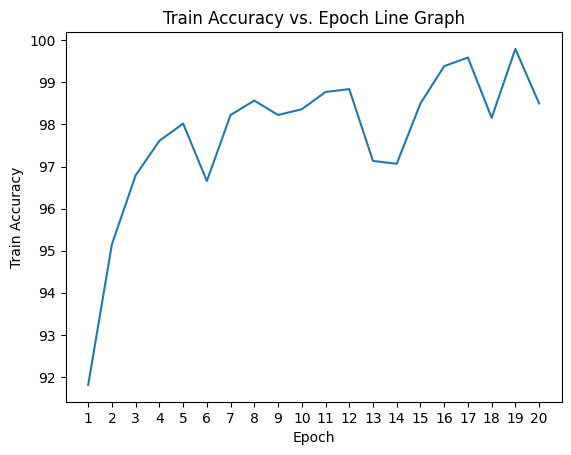

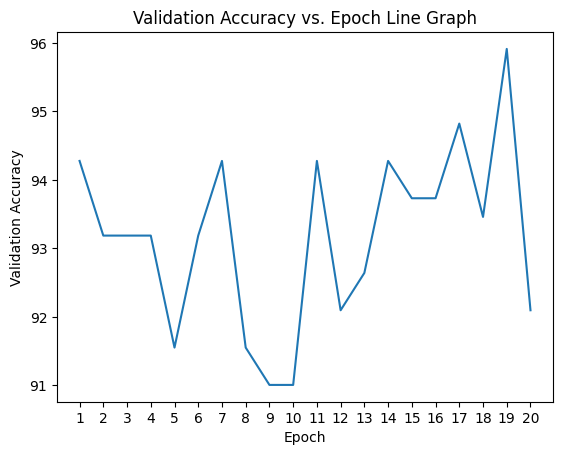

Test Loss: 0.706980, Test Accuracy: 88.235294%


In [12]:
# Single block to train/validate/test 8th MLP (since this is the one that mainly gets stuck)
run_process(mlp_8, train_loader, val_loader, test_loader, num_epochs, 8)
torch.save(mlp_8.state_dict(), f"mlp_models/mlp_8.pth")

In [13]:
for mlp in mlps:
    del mlp
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
# Loop to train, validate, and test all CNNs
for i in range(9):
    print(f'Now running CNN #{i+1}...')
    run_process(cnns[i], train_loader, val_loader, test_loader, num_epochs, i + 1)